---
**Turma:** 15

**Grupo:** 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`

**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

---
# Neural Network

In [0]:
root_dir = '/dbfs/FileStore/ifood'

dbutils.fs.ls(f'{root_dir}')

Out[2]: [FileInfo(path='dbfs:/dbfs/FileStore/ifood/abt/', name='abt/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/customer_segmentation/', name='customer_segmentation/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/enrich/', name='enrich/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/marketing_push_full/', name='marketing_push_full/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders/', name='orders/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders_with_cost_revenue/', name='orders_with_cost_revenue/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/preprocess/', name='preprocess/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/sessions_visits/', name='sessions_visits/', size=0)]

### Load ABT Train Test

In [0]:
abt = 'abt_case_aug_half_end'

df_abt_case_train = spark.read.parquet(
  f'{root_dir}/abt/{abt}_train'
).repartition(2).cache()
df_abt_case_train.createOrReplaceTempView(f'{abt}_train')
df_abt_case_train.createOrReplaceTempView('abt_train')

df_abt_case_test = spark.read.parquet(
  f'{root_dir}/abt/{abt}_test'
).repartition(2).cache()
df_abt_case_test.createOrReplaceTempView(f'{abt}_test')
df_abt_case_test.createOrReplaceTempView('abt_test')

df_abt_case_train.count(), df_abt_case_test.count()

Out[3]: (21036, 9043)

### VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

featureList = [c for c in df_abt_case_train.columns if c not in ['label', 'customer_id']]

assembler = VectorAssembler(inputCols=featureList, outputCol = 'features')

dfAssemblerTrain = assembler.transform(df_abt_case_train)
dfAssemblerTest  = assembler.transform(df_abt_case_test)

# Pipeline

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import MultilayerPerceptronClassifier

neuralClassifier = MultilayerPerceptronClassifier(
  featuresCol='features',
  labelCol='label',
  layers=[
    len(featureList),
    8,
    2
  ]
)

pipeline = Pipeline(stages=[neuralClassifier])

#### Training

In [0]:
model = pipeline.fit(dfAssemblerTrain)

### Evaluation on Test

In [0]:
dfPrediction = model.transform(dfAssemblerTest)

#### Metric ROC PR

In [0]:
import pandas as pd

evaluator = BinaryClassificationEvaluator()

pdPrection = pd.DataFrame({
  "areaUnderROC": [evaluator.setMetricName("areaUnderROC").evaluate(dfPrediction)],
  "areaUnderPR": [evaluator.setMetricName("areaUnderPR").evaluate(dfPrediction)]
})

pdPrection.transpose()

,0
areaUnderROC,0.935499
areaUnderPR,0.882586


#### Confussion Matrix

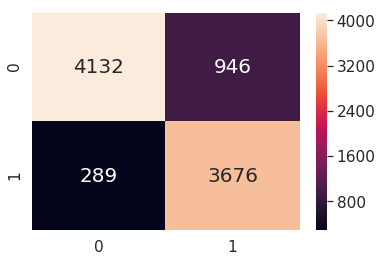

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pdCvMatrix = dfPrediction.select('label', 'prediction').toPandas()

cm = confusion_matrix(pdCvMatrix['label'], pdCvMatrix['prediction'])

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='g')

#### Classification Report

In [0]:
from sklearn.metrics import classification_report 
import pandas as pd
pd.set_option('display.precision', 6)

dfReport = dfPrediction.select('label', 'prediction').toPandas()

dict = classification_report(dfReport['label'], dfReport['prediction'], output_dict=True)
pd.DataFrame(dict)

,0,1,micro avg,macro avg,weighted avg
f1-score,0.869986,0.856178,0.86343,0.863082,0.863932
precision,0.934630,0.795327,0.86343,0.864978,0.873551
recall,0.813706,0.927112,0.86343,0.870409,0.863430
support,5078.000000,3965.000000,9043.00000,9043.000000,9043.000000
